In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

In [2]:
train_images = glob.glob("input/train_images_processed_1024/*/*")
roi_output_base = "input/roi/train_images_roi"
IMG_SIZE = 1024

In [3]:
train_images[:5]

['input/train_images_processed_1024/1069/1313414003.png',
 'input/train_images_processed_1024/1069/725941064.png',
 'input/train_images_processed_1024/1069/1311352975.png',
 'input/train_images_processed_1024/1069/426661175.png',
 'input/train_images_processed_1024/48123/1885792542.png']

In [4]:
def crop_coords(img):
    """
    Crop ROI from image.
    """
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    return (x, y, w, h)


def truncation_normalization(img):
    """
    Clip and normalize pixels in the breast ROI.
    @img : numpy array image
    return: numpy array of the normalized image
    """
    Pmin = np.percentile(img[img!=0], 5)
    Pmax = np.percentile(img[img!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[img==0]=0
    return normalized


def clahe(img, clip):
    """
    Image enhancement.
    @img : numpy array image
    @clip : float, clip limit for CLAHE algorithm
    return: numpy array of the enhanced image
    """
    clahe = cv2.createCLAHE(clipLimit=clip)
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [5]:
for img_path in tqdm(train_images):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    coords = crop_coords(img)
    if coords is None:
        continue

    x, y, w, h = coords
    img_cropped = img[y:y+h, x:x+w]
    img_normalized = truncation_normalization(img_cropped)
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)
    img_final = cv2.merge((np.array(img_normalized * 255, dtype=np.uint8), cl1, cl2))
    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))

    # Build the output path using the same subdirectory structure
    rel_path = os.path.relpath(img_path, "input/train_images_processed_1024")
    output_path = os.path.join(roi_output_base, rel_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save the processed ROI image
    cv2.imwrite(output_path, img_final)

 75%|███████▍  | 41004/54706 [23:17<08:29, 26.89it/s]/var/folders/z7/vw01v7xx5qn8l2s2qdl4kbyh0000gn/T/ipykernel_5899/3337448259.py:24: RuntimeWarning: invalid value encountered in divide
  normalized = (truncated - Pmin)/(Pmax - Pmin)
/var/folders/z7/vw01v7xx5qn8l2s2qdl4kbyh0000gn/T/ipykernel_5899/3337448259.py:37: RuntimeWarning: invalid value encountered in cast
  cl = clahe.apply(np.array(img*255, dtype=np.uint8))
/var/folders/z7/vw01v7xx5qn8l2s2qdl4kbyh0000gn/T/ipykernel_5899/3788531767.py:15: RuntimeWarning: invalid value encountered in cast
  img_final = cv2.merge((np.array(img_normalized * 255, dtype=np.uint8), cl1, cl2))
100%|██████████| 54706/54706 [31:14<00:00, 29.19it/s]


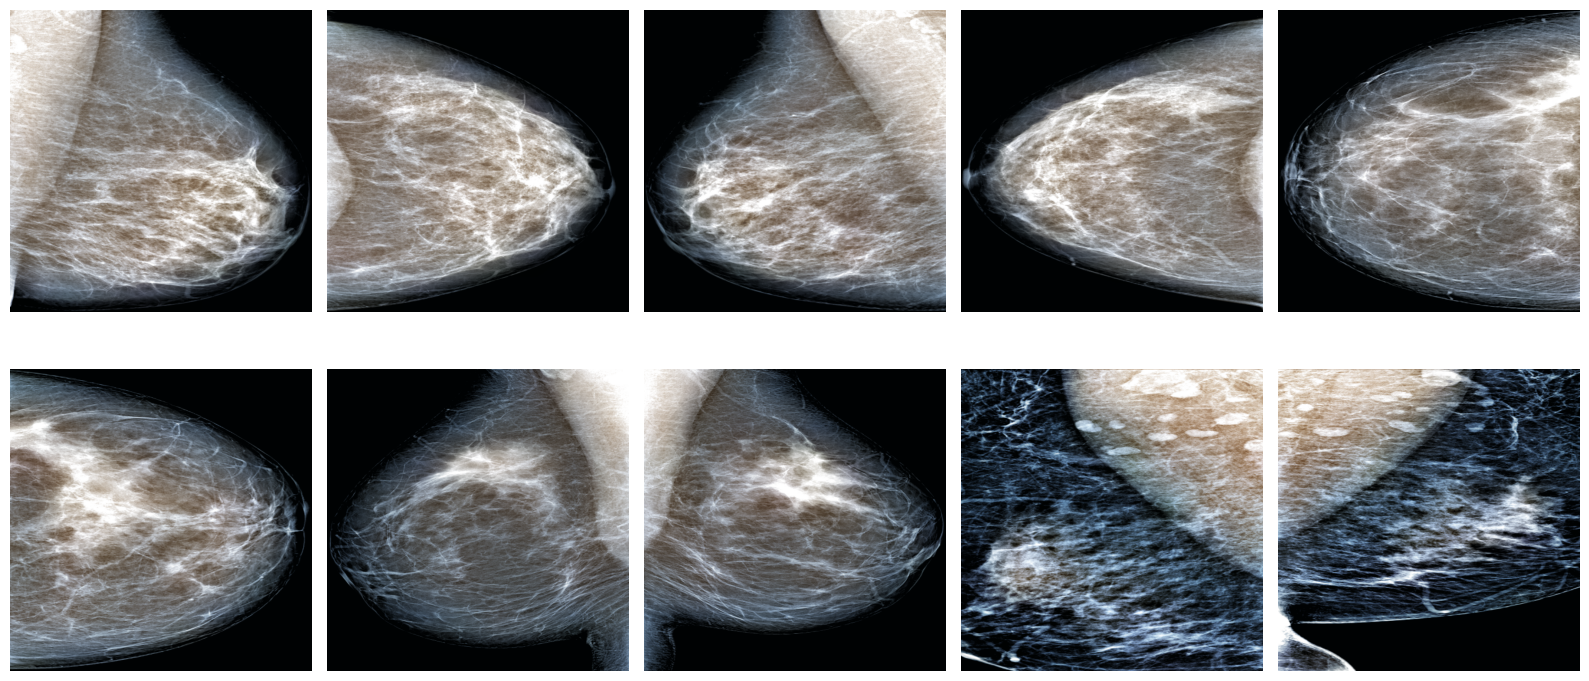

In [7]:
_, axs = plt.subplots(2, 5, figsize=(16, 8))
axs = axs.flatten()
IMG_SIZE = 512

final_imgs = []
for img_path, ax in zip(train_images[:10], axs):  # Just show first 10 images
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    coords = crop_coords(img)
    if coords is None:
        continue

    x, y, w, h = coords
    img_cropped = img[y:y+h, x:x+w]
    img_normalized = truncation_normalization(img_cropped)
    
    # CLAHE-enhanced versions
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)

    # Merge into 3-channel image
    img_final = cv2.merge((np.array(img_normalized * 255, dtype=np.uint8), cl1, cl2))
    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))

    final_imgs.append(img_final)
    ax.imshow(img_final)
    ax.axis("off")

plt.tight_layout()
plt.savefig("final_imgs.png")
plt.show()

In [8]:
import os

roi_output_base = "input/roi/train_images_roi"

for img_path, ax in zip(train_images[:10], axs):
    # ... [same processing code as before] ...
    img_normalized = truncation_normalization(img_cropped)
    cl1 = clahe(img_normalized, 1.0)
    cl2 = clahe(img_normalized, 2.0)
    img_final = cv2.merge((np.array(img_normalized*255, dtype=np.uint8), cl1, cl2))
    img_final = cv2.resize(img_final, (IMG_SIZE, IMG_SIZE))
    ax.imshow(img_final)

    # --- New code for saving the ROI image ---
    # Get relative path after 'train_images_processed_1024/'
    rel_path = os.path.relpath(img_path, "input/train_images_processed_1024")
    
    # Build output path in 'roi/train_images'
    output_path = os.path.join(roi_output_base, rel_path)

    # Create output directory if it doesn't exist
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save the image (as PNG or JPG)
    cv2.imwrite(output_path, img_final)